## Load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.stats as st

quiet_event = 'G0H3-201804202100' 
moderate_event = 'G2H12-201509071500'
storm_event = 'G4H12-202304231500'
sfno_quiet_event = 'G0H12-201804202100'

models_path = '/mnt/ionosphere-experiments/20250815-presentation/'
sfno_models_path = '/mnt/ionosphere-experiments/neurips2025-ml4ps-submission/'

# lead_times = np.arange(1, 13, 1) * 60 # Every 60 minutes over 24 hours
lead_times = [60, 120]
print(lead_times)

def compute_rmse(ground_truth, prediction):
    """Compute the Root Mean Square Error between ground truth and prediction."""
    return np.sqrt(np.mean(np.power((ground_truth.flatten() - prediction.flatten()),2)))

def compute_lat_rmse(ground_truth, prediction):
    """Compute RMSE for low, mid, and high latitude bands.
    Accepts lat in either -90 to 90 or 0 to 180 (north to south).
    Returns a dict with keys 'low', 'mid', 'high'.
    """
    lat = np.arange(0, 180, 1)
    # If lat is 0-180, convert to -90 to 90 (assuming 0=north, 180=south)
    if np.all((lat >= 0) & (lat <= 180)):
        lat = 90 - lat
    # Indices for bands
    low_idx = np.where((lat >= -30) & (lat <= 30))[0]
    mid_idx = np.where(((lat >= -60) & (lat < -30)) | ((lat > 30) & (lat <= 60)))[0]
    high_idx = np.where(((lat >= -90) & (lat < -60)) | ((lat > 60) & (lat <= 90)))[0]

    def band_rmse(idx):
        if len(idx) == 0:
            return np.nan
        gt_band = ground_truth[:, idx, :].flatten()
        pred_band = prediction[:, idx, :].flatten()
        return np.sqrt(np.mean((gt_band - pred_band) ** 2))

    return {
        'low': band_rmse(low_idx),
        'mid': band_rmse(mid_idx),
        'high': band_rmse(high_idx)
    }

# Compute persistence RMSE for each event
def persistence_rmse(gt, lead_time):
    lead_time_idx = int(lead_time // 60)  # assuming 60 min per step

    pred = gt[:-lead_time_idx]
    target = gt[lead_time_idx:]

    global_rmse = compute_rmse(target, pred)
    lat_rmse = compute_lat_rmse(target, pred)

    return global_rmse, lat_rmse

[60, 120]


In [4]:
##### Load long horizon data
# Load JPLD data
quiet_JPLD_data_event = f'IonCastGNN/test-long-horizon-event-{quiet_event}-original.npy'
moderate_JPLD_data_event = f'IonCastGNN/test-long-horizon-event-{moderate_event}-original.npy'
severe_JPLD_data_event = f'IonCastGNN/test-long-horizon-event-{storm_event}-original.npy'

JPLD_quiet_data_long = np.load(models_path + quiet_JPLD_data_event)
JPLD_moderate_data_long = np.load(models_path + moderate_JPLD_data_event)
JPLD_severe_data_long = np.load(models_path + severe_JPLD_data_event)

print(f'Loaded long horizon JPLD data shapes: Quiet {JPLD_quiet_data_long.shape}, Moderate {JPLD_moderate_data_long.shape}, Severe {JPLD_severe_data_long.shape}')

# Load LSTM data
quiet_LSTM_data_event = f'IonCastLSTM/test-long-horizon-event-{quiet_event}-forecast.npy'
moderate_LSTM_data_event = f'IonCastLSTM/test-long-horizon-event-{moderate_event}-forecast.npy'
severe_LSTM_data_event = f'IonCastLSTM/test-long-horizon-event-{storm_event}-forecast.npy'

LSTM_quiet_data_long = np.load(models_path + quiet_LSTM_data_event)
LSTM_moderate_data_long = np.load(models_path + moderate_LSTM_data_event)
LSTM_severe_data_long = np.load(models_path + severe_LSTM_data_event)

print(f'Loaded long horizon LSTM data shapes: Quiet {LSTM_quiet_data_long.shape}, Moderate {LSTM_moderate_data_long.shape}, Severe {LSTM_severe_data_long.shape}')

# Load GNN data
quiet_GNN_data_event = f'IonCastGNN/test-long-horizon-event-{quiet_event}-forecast.npy'
moderate_GNN_data_event = f'IonCastGNN/test-long-horizon-event-{moderate_event}-forecast.npy'
severe_GNN_data_event = f'IonCastGNN/test-long-horizon-event-{storm_event}-forecast.npy'

GNN_quiet_data_long = np.load(models_path + quiet_GNN_data_event)
GNN_moderate_data_long = np.load(models_path + moderate_GNN_data_event)
GNN_severe_data_long = np.load(models_path + severe_GNN_data_event)

print(f'Loaded long horizon GNN data shapes: Quiet {GNN_quiet_data_long.shape}, Moderate {GNN_moderate_data_long.shape}, Severe {GNN_severe_data_long.shape}')

# Load SFNO data
quiet_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-long-horizon-event-{sfno_quiet_event}-forecast.npy'
moderate_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-long-horizon-event-{moderate_event}-forecast.npy'
severe_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-long-horizon-event-{storm_event}-forecast.npy'

SFNO_quiet_data_long = np.load(sfno_models_path + quiet_SFNO_data_event)
SFNO_moderate_data_long = np.load(sfno_models_path + moderate_SFNO_data_event)
SFNO_severe_data_long = np.load(sfno_models_path + severe_SFNO_data_event)

print(f'Loaded long horizon SFNO data shapes: Quiet {SFNO_quiet_data_long.shape}, Moderate {SFNO_moderate_data_long.shape}, Severe {SFNO_severe_data_long.shape}')

datasets_long = [
    ('JPLD Quiet', JPLD_quiet_data_long),
    ('LSTM Quiet', LSTM_quiet_data_long),
    ('SFNO Quiet', SFNO_quiet_data_long),
    ('GNN Quiet', GNN_quiet_data_long),
    ('JPLD Moderate', JPLD_moderate_data_long),
    ('LSTM Moderate', LSTM_moderate_data_long),
    ('SFNO Moderate', SFNO_moderate_data_long),
    ('GNN Moderate', GNN_moderate_data_long),
    ('JPLD Severe', JPLD_severe_data_long),
    ('LSTM Severe', LSTM_severe_data_long),
    ('SFNO Severe', SFNO_severe_data_long),
    ('GNN Severe', GNN_severe_data_long),
]

# Load the ground data and the model lead time outputs
datasets_rmse = {}  # RMSE
datasets_rmse_long = {}  # RMSE for long horizon

for lead_time in lead_times:
    # Load JPLD reference data
    jpld_data_quiet_event = f'IonCastGNN/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-original.npy'
    jpld_data_moderate_event = f'IonCastGNN/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-original.npy'
    jpld_data_severe_event = f'IonCastGNN/test-fixed-lead-time-event-{storm_event}-{lead_time}min-original.npy'

    quiet_jpld_data = np.load(models_path + jpld_data_quiet_event)
    moderate_jpld_data = np.load(models_path + jpld_data_moderate_event)
    severe_jpld_data = np.load(models_path + jpld_data_severe_event)

    print(f'Loaded JPLD data shapes: Quiet {quiet_jpld_data.shape}, Moderate {moderate_jpld_data.shape}, Severe {severe_jpld_data.shape}')
    print(f'Mean value JPLD: {np.mean(quiet_jpld_data):.2f}, {np.mean(moderate_jpld_data):.2f}, {np.mean(severe_jpld_data):.2f}')
    print(f"first 10 values of lat = 1 and lon = 1: {quiet_jpld_data[:10, 1, 1]}")

    # Load LSTM data
    quiet_LSTM_data_event = f'IonCastLSTM/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-forecast.npy'
    moderate_LSTM_data_event = f'IonCastLSTM/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    severe_LSTM_data_event = f'IonCastLSTM/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    LSTM_quiet_data = np.load(models_path + quiet_LSTM_data_event)
    LSTM_moderate_data = np.load(models_path + moderate_LSTM_data_event)
    LSTM_severe_data = np.load(models_path + severe_LSTM_data_event)

    print(f'Loaded LSTM data shapes: Quiet {LSTM_quiet_data.shape}, Moderate {LSTM_moderate_data.shape}, Severe {LSTM_severe_data.shape}')

    # Load GNN data
    quiet_GNN_data_event = f'IonCastGNN/test-fixed-lead-time-event-{quiet_event}-{lead_time}min-forecast.npy'
    moderate_GNN_data_event = f'IonCastGNN/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    severe_GNN_data_event = f'IonCastGNN/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    GNN_quiet_data = np.load(models_path + quiet_GNN_data_event)
    GNN_moderate_data = np.load(models_path + moderate_GNN_data_event)
    GNN_severe_data = np.load(models_path + severe_GNN_data_event)

    print(f'Loaded GNN data shapes: Quiet {GNN_quiet_data.shape}, Moderate {GNN_moderate_data.shape}, Severe {GNN_severe_data.shape}')
   
   # Load SFNO data
    quiet_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-fixed-lead-time-event-{sfno_quiet_event}-{lead_time}min-forecast.npy'
    moderate_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    severe_SFNO_data_event = f'IonCastSFNO/full_datarange_4c4p/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    SFNO_quiet_data = np.load(sfno_models_path + quiet_SFNO_data_event)
    SFNO_moderate_data = np.load(sfno_models_path + moderate_SFNO_data_event)
    SFNO_severe_data = np.load(sfno_models_path + severe_SFNO_data_event)

    print(f'Loaded SFNO data shapes: Quiet {SFNO_quiet_data.shape}, Moderate {SFNO_moderate_data.shape}, Severe {SFNO_severe_data.shape}')

    # Load Persistence data
    persistence_data_quiet_event = f'IonCastPersistence/test-fixed-lead-time-event-{sfno_quiet_event}-{lead_time}min-forecast.npy'
    persistence_data_moderate_event = f'IonCastPersistence/test-fixed-lead-time-event-{moderate_event}-{lead_time}min-forecast.npy'
    persistence_data_severe_event = f'IonCastPersistence/test-fixed-lead-time-event-{storm_event}-{lead_time}min-forecast.npy'

    quiet_persistence_data = np.load(sfno_models_path + persistence_data_quiet_event)
    moderate_persistence_data = np.load(sfno_models_path + persistence_data_moderate_event)
    severe_persistence_data = np.load(sfno_models_path + persistence_data_severe_event)

    print(f'Loaded Persistence data shapes: Quiet {quiet_persistence_data.shape}, Moderate {moderate_persistence_data.shape}, Severe {severe_persistence_data.shape}')
    print(f'Mean value persistence: {np.mean(quiet_persistence_data):.2f}, {np.mean(moderate_persistence_data):.2f}, {np.mean(severe_persistence_data):.2f}')
    print(f"first 10 values of lat = 1 and lon = 1: {quiet_persistence_data[:10, 1, 1]}")

    #compute RMSE for each model and event and print a table
    datasets = [
        ('JPLD Quiet', quiet_jpld_data),
        ('LSTM Quiet', LSTM_quiet_data),
        ('GNN Quiet', GNN_quiet_data),
        ('SFNO Quiet', SFNO_quiet_data),
        ('Persistence Quiet', quiet_persistence_data),
        ('JPLD Moderate', moderate_jpld_data),
        ('LSTM Moderate', LSTM_moderate_data),
        ('GNN Moderate', GNN_moderate_data),
        ('SFNO Moderate', SFNO_moderate_data),
        ('Persistence Moderate', moderate_persistence_data),
        ('JPLD Severe', severe_jpld_data),
        ('LSTM Severe', LSTM_severe_data),
        ('GNN Severe', GNN_severe_data),
        ('SFNO Severe', SFNO_severe_data),
        ('Persistence Severe', severe_persistence_data),
    ]

    for name, data in datasets:
        if 'Quiet' in name:
            gt = quiet_jpld_data
        elif 'Moderate' in name:
            gt = moderate_jpld_data
        elif 'Severe' in name:
            gt = severe_jpld_data
        else:
            continue  # Should not happen

        global_rmse = compute_rmse(gt, data)
        lat_rmse = compute_lat_rmse(gt, data)
        
        if lead_time == lead_times[0]:
            datasets_rmse[name] = {'low': [], 'mid': [], 'high': [], 'global': []}

        datasets_rmse[name]['global'].append(global_rmse)
        datasets_rmse[name]['low'].append(lat_rmse['low'])
        datasets_rmse[name]['mid'].append(lat_rmse['mid'])
        datasets_rmse[name]['high'].append(lat_rmse['high'])
        print(f"RMSE for {name} and lead_time {lead_time}: {global_rmse:.2f} (low: {lat_rmse['low']:.2f}, mid: {lat_rmse['mid']:.2f}, high: {lat_rmse['high']:.2f})")


    # Add persistence RMSE for each event
    for event_name, gt in [('Quiet', quiet_jpld_data), ('Moderate', moderate_jpld_data), ('Severe', severe_jpld_data)]:
        key = f'Persistence {event_name}'
        if lead_time == lead_times[0]:
            datasets_rmse[key] = {'low': [], 'mid': [], 'high': [], 'global': []}
        global_rmse, lat_rmse = persistence_rmse(gt, lead_time)
        datasets_rmse[key]['global'].append(global_rmse)
        datasets_rmse[key]['low'].append(lat_rmse['low'])
        datasets_rmse[key]['mid'].append(lat_rmse['mid'])
        datasets_rmse[key]['high'].append(lat_rmse['high'])
        print(f'Persistence RMSE for {event_name} and lead_time {lead_time}: {global_rmse:.2f} (low: {lat_rmse['low']:.2f}, mid: {lat_rmse['mid']:.2f}, high: {lat_rmse['high']:.2f})')

# Calculate RMSE for long horizon data
for name, data in datasets_long:
    if 'Quiet' in name:
        gt = JPLD_quiet_data_long
    elif 'Moderate' in name:
        gt = JPLD_moderate_data_long
    elif 'Severe' in name:
        gt = JPLD_severe_data_long
    else:
        continue  # Should not happen

    global_rmse = compute_rmse(gt, data)
    lat_rmse = compute_lat_rmse(gt, data)

    datasets_rmse_long[name] = {
        'global': global_rmse,
        'low': lat_rmse['low'],
        'mid': lat_rmse['mid'],
        'high': lat_rmse['high']
    }
    print(f"Long horizon RMSE for {name}: {global_rmse:.2f} (low: {lat_rmse['low']:.2f}, mid: {lat_rmse['mid']:.2f}, high: {lat_rmse['high']:.2f})")

print(datasets_rmse)
print(datasets_rmse_long)
lat_size = quiet_jpld_data.shape[1]
lon_size = quiet_jpld_data.shape[2]

datasets_lead = [
    ('JPLD Quiet', quiet_jpld_data),
    ('LSTM Quiet', LSTM_quiet_data),
    ('SFNO Quiet', SFNO_quiet_data),
    ('GNN Quiet', GNN_quiet_data),
    ('JPLD Moderate', moderate_jpld_data),
    ('LSTM Moderate', LSTM_moderate_data),
    ('SFNO Moderate', SFNO_moderate_data),
    ('GNN Moderate', GNN_moderate_data),
    ('JPLD Severe', severe_jpld_data),
    ('LSTM Severe', LSTM_severe_data),
    ('SFNO Severe', SFNO_severe_data),
    ('GNN Severe', GNN_severe_data),
]

Loaded long horizon JPLD data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded long horizon LSTM data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded long horizon GNN data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded long horizon SFNO data shapes: Quiet (48, 180, 360), Moderate (48, 180, 360), Severe (48, 180, 360)
Loaded JPLD data shapes: Quiet (49, 180, 360), Moderate (49, 180, 360), Severe (49, 180, 360)
Mean value JPLD: 8.05, 13.15, 26.55
first 10 values of lat = 1 and lon = 1: [3.2000003 3.4       3.6999998 3.8       3.8999999 3.8       3.8
 3.6999998 3.6       3.6      ]
Loaded LSTM data shapes: Quiet (49, 180, 360), Moderate (49, 180, 360), Severe (49, 180, 360)
Loaded GNN data shapes: Quiet (49, 180, 360), Moderate (49, 180, 360), Severe (49, 180, 360)
Loaded SFNO data shapes: Quiet (49, 180, 360), Moderate (49, 180, 360), Severe (49, 180, 360)
Loaded Persistence data s

## Gif of predictions over time

GIF saved as tec_maps_grid.gif


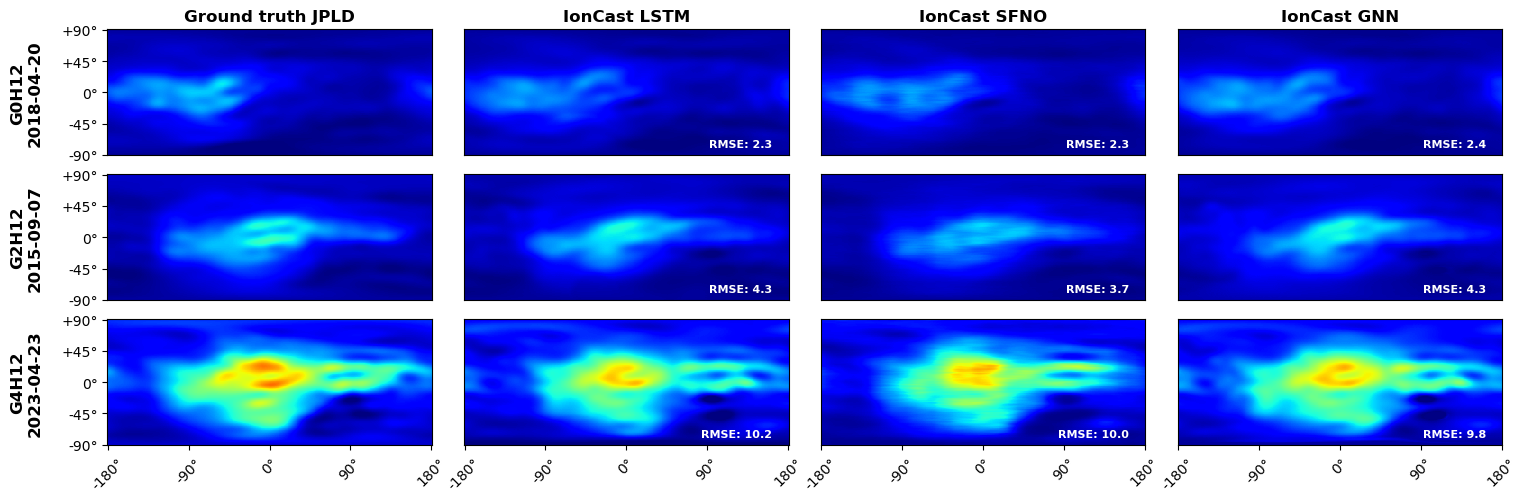

In [5]:
# --------------------------------
# Geographic setup
# --------------------------------
lon = np.linspace(-180, 180, 360)
lat = np.linspace(90, -90, 180)
nrows, ncols = 3, 4
n_times = quiet_jpld_data.shape[0]
col_titles = ["Ground truth JPLD", "IonCast LSTM", "IonCast SFNO", "IonCast GNN"]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

vmin, vmax = 0, 120

# -----------------------------
# Create figure + subplots once- LEAD TIME VERSION
# -----------------------------
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5.4))
axes = axes.flatten()
pcm_list = []

event_labels = ['G0H12\n2018-04-20', 'G2H12\n2015-09-07', 'G4H12\n2023-04-23']

for idx, ax in enumerate(axes):
    vtec_map = datasets_lead[idx][1][0]
    pcm = ax.pcolormesh(lon, lat, vtec_map, cmap='jet', vmin=vmin, vmax=vmax, shading='auto')
    pcm_list.append(pcm)

    # Titles for first row
    if idx < ncols:
        ax.set_title(col_titles[idx], fontsize=12, fontweight='bold')

    # Y-axis ticks for first column
    if idx % ncols == 0:
        ax.set_yticks([-90, -45, 0, 45, 90])
        ax.set_yticklabels(['-90°', '-45°', '0°', '+45°', '+90°'])

        row_idx = idx // ncols
        ax.text(-0.25, 0.5, event_labels[row_idx], rotation=90, va='center', ha='center',
                transform=ax.transAxes, fontsize=12, fontweight='bold')
    else:
        ax.set_yticks([])

    # X-axis ticks for last row
    if idx >= (nrows - 1) * ncols:
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_xticklabels(['-180°', '-90°', '0°', '90°', '180°'])
        ax.tick_params(axis='x', rotation=45)   
       
    else:
        ax.set_xticks([])


    #write RMSE in the bottom right corner for all columns except the second column
    if idx % ncols != 0:
        rmse_value = datasets_rmse[datasets_lead[idx][0]]['global'][1]
        ax.text(0.95, 0.05, f'RMSE: {rmse_value:.1f}', transform=ax.transAxes,
                fontsize=8, color='white', ha='right', va='bottom', fontweight='bold')
    

# Shared colorbar
#fig.colorbar(pcm_list[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.02).set_label('TEC (TECU)', fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.15)
#plt.tight_layout()

# -----------------------------
# Update function for animation
# -----------------------------
def update(frame_idx):
    for idx, pcm in enumerate(pcm_list):
        pcm.set_array(datasets_lead[idx][1][frame_idx].ravel())
    #fig.suptitle(f"TEC Maps — {time_labels[frame_idx]}", fontsize=16)
    return pcm_list

# -----------------------------
# Create and save animation
# -----------------------------
ani = animation.FuncAnimation(fig, update, frames=n_times, interval=200, blit=False)
ani.save("../results/final_showcase_plots/tec_maps_lead_grid.gif", writer='pillow', fps=4)
print("GIF saved as tec_maps_grid.gif")


GIF saved as tec_maps_grid.gif


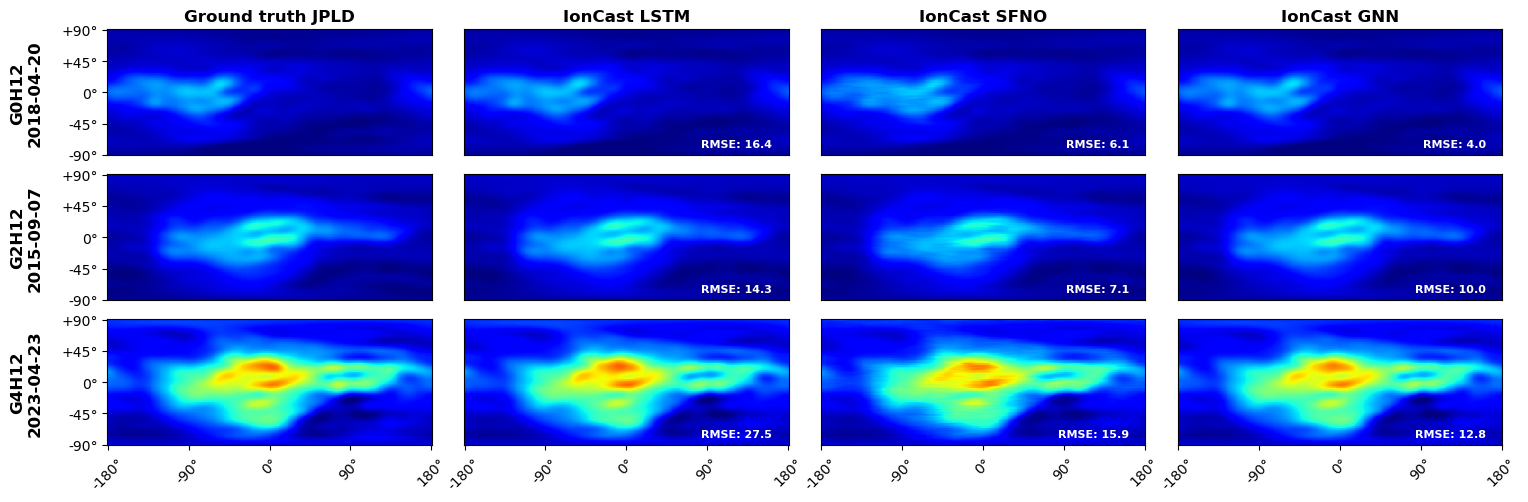

In [7]:
# --------------------------------
# Geographic setup
# --------------------------------
lon = np.linspace(-180, 180, 360)
lat = np.linspace(90, -90, 180)
nrows, ncols = 3, 4
n_times = JPLD_quiet_data_long.shape[0]
col_titles = ["Ground truth JPLD", "IonCast LSTM", "IonCast SFNO", "IonCast GNN"]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

vmin, vmax = 0, 120

# -----------------------------
# Create figure + subplots once- LONG HORIZON VERSION
# -----------------------------
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5.4))
axes = axes.flatten()
pcm_list = []

event_labels = ['G0H12\n2018-04-20', 'G2H12\n2015-09-07', 'G4H12\n2023-04-23']

for idx, ax in enumerate(axes):
    vtec_map = datasets_long[idx][1][0]
    pcm = ax.pcolormesh(lon, lat, vtec_map, cmap='jet', vmin=vmin, vmax=vmax, shading='auto')
    pcm_list.append(pcm)

    # Titles for first row
    if idx < ncols:
        ax.set_title(col_titles[idx], fontsize=12, fontweight='bold')

    # Y-axis ticks for first column
    if idx % ncols == 0:
        ax.set_yticks([-90, -45, 0, 45, 90])
        ax.set_yticklabels(['-90°', '-45°', '0°', '+45°', '+90°'])

        row_idx = idx // ncols
        ax.text(-0.25, 0.5, event_labels[row_idx], rotation=90, va='center', ha='center',
                transform=ax.transAxes, fontsize=12, fontweight='bold')
    else:
        ax.set_yticks([])

    # X-axis ticks for last row
    if idx >= (nrows - 1) * ncols:
        ax.set_xticks([-180, -90, 0, 90, 180])
        ax.set_xticklabels(['-180°', '-90°', '0°', '90°', '180°'])
        ax.tick_params(axis='x', rotation=45)   
       
    else:
        ax.set_xticks([])


    #write RMSE in the bottom right corner for all columns except the second column
    if idx % ncols != 0:
        rmse_value = datasets_rmse_long[datasets_long[idx][0]]['global']
        ax.text(0.95, 0.05, f'RMSE: {rmse_value:.1f}', transform=ax.transAxes,
                fontsize=8, color='white', ha='right', va='bottom', fontweight='bold')
    

# Shared colorbar
#fig.colorbar(pcm_list[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.02).set_label('TEC (TECU)', fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.15)
#plt.tight_layout()

# -----------------------------
# Update function for animation
# -----------------------------
def update(frame_idx):
    for idx, pcm in enumerate(pcm_list):
        pcm.set_array(datasets_long[idx][1][frame_idx].ravel())
    #fig.suptitle(f"TEC Maps — {time_labels[frame_idx]}", fontsize=16)
    return pcm_list

# -----------------------------
# Create and save animation
# -----------------------------
ani = animation.FuncAnimation(fig, update, frames=n_times, interval=200, blit=False)
ani.save("../results/final_showcase_plots/tec_maps_long_grid.gif", writer='pillow', fps=4)
print("GIF saved as tec_maps_grid.gif")
